In [1]:
import numpy as np

import sys
sys.path.insert(
    1,
    '/home/dtd/Documents/interpretable_machine_learning/Source Code/my_work/lib'
)

import data_load
import numpy as np
import pandas as pd
import logging
import incremental_ps_score_estimator as ipse
import utils


from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from geneticalgorithm import geneticalgorithm as ga


In [2]:
file_path = "https://msalicedatapublic.blob.core.windows.net/datasets/Pricing/pricing_sample.csv"
train_data = pd.read_csv(file_path)

In [3]:
train_data['treatment'] = np.where(train_data['price'] == 1, 1, 0)
train_data['price'] = np.where(train_data['price'] == 1, 1, 0.85)

In [ ]:
train_data, test_data 

In [4]:
outcome = "demand"
treatment = "treatment"
col = list(train_data.columns)
col.remove("price")
print(col)

cov = col[:]
cov.remove(treatment)
cov.remove(outcome)
cov.remove('income')
print(cov)

features = col[:]
features.remove(outcome)

print(features)

['account_age', 'age', 'avg_hours', 'days_visited', 'friends_count', 'has_membership', 'is_US', 'songs_purchased', 'income', 'demand', 'treatment']
['account_age', 'age', 'avg_hours', 'days_visited', 'friends_count', 'has_membership', 'is_US', 'songs_purchased']
['account_age', 'age', 'avg_hours', 'days_visited', 'friends_count', 'has_membership', 'is_US', 'songs_purchased', 'income', 'treatment']


In [15]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(train_data, test_size=0.7)

In [16]:
## Fit treatment
model_t = LogisticRegression()
model_t.fit(train_data[cov], train_data[treatment])

train_data['p1'] = model_t.predict_proba(train_data[cov])[:,1]
train_data['p0'] = 1 - train_data['p1']

train_data["prediction"] = np.where(train_data["p1"] >= 0.5, 1, 0)

## Fit outcome
model_y = GradientBoostingRegressor(random_state=0, n_estimators = 1000)
model_y.fit(train_data[features], train_data[outcome])

    

GradientBoostingRegressor(n_estimators=1000, random_state=0)

In [17]:
train_data.shape

(3000, 15)

## Optimization

In [6]:
def fitness_function(propensity_score):
    policy = np.where(propensity_score >= 0.5, 1, 0)
    return np.mean(revenue_fn(train_data,  0, 0.1, 1, policy))

In [7]:
initial_population = np.concatenate((np.random.normal(50, 100, (3000,train_data.shape[0])),
                                np.random.normal(0, 0.9, (100,train_data.shape[0]))))

initial_population = initial_population.transpose()

In [8]:
initial_population.shape

(10000, 3100)

In [21]:
def gamma_fn(X):
    return -3 - 14 * (X["income"] < 1)

def beta_fn(X):
    return 20 + 0.5 * (X["avg_hours"]) + 5 * (X["days_visited"] > 4)

def demand_fn(data, T):
    Y = gamma_fn(data) * T + beta_fn(data)
    return Y

def true_te(x, n, stats):
    if x < 1:
        subdata = df[df["income"] < 1].sample(n=n, replace=True)
    else:
        subdata = df[df["income"] >= 1].sample(n=n, replace=True)
    te_array = subdata["price"] * gamma_fn(subdata) / (subdata["demand"])
    if stats == "mean":
        return np.mean(te_array)
    elif stats == "median":
        return np.median(te_array)
    elif isinstance(stats, int):
        return np.percentile(te_array, stats)
    
def revenue_fn(data, discount_level1, discount_level2, baseline_T, policy):
    policy_price = baseline_T * (1 - discount_level1) * policy + baseline_T * (1 - discount_level2) * (1 - policy)
    demand = demand_fn(data, policy_price)
    rev = demand * policy_price
    return rev

In [22]:
varbound=np.array(initial_population)
vartype=np.array([['real'] for _ in range(10000)])

model=ga(function=fitness_function,
         dimension=10000,
         variable_type_mixed=vartype,
         variable_boundaries=varbound)

model.run()


AssertionError: 
 boundary for each variable must be a tuple of length two.

In [10]:
varbound.shape

(10000, 3100)

 The best solution found:                                                                           
 [0.50017902 1.         0.        ]

 Objective function:
 1.5001790188431277


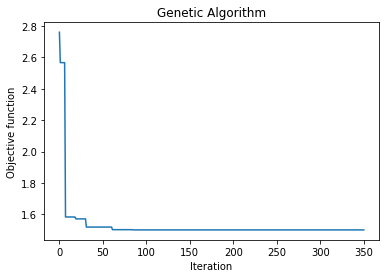

In [11]:
import numpy as np
from geneticalgorithm import geneticalgorithm as ga

def f(X):
    return np.sum(X)

varbound=np.array([[0.5,1.5],[1,100],[0,1]])
vartype=np.array([['real'],['int'],['int']])
model=ga(function=f,dimension=3,variable_type_mixed=vartype,variable_boundaries=varbound)

model.run()


In [23]:
import numpy as np
from geneticalgorithm import geneticalgorithm as ga

def f(X):
    return -np.sum(X)

varbound=np.array([[0,10]]*train_data.shape[0])

# model=ga(function=f,dimension=train_data.shape[0],variable_type='real',variable_boundaries=varbound)

# model.run()

In [ ]:
model=ga(function=fitness_function,dimension=train_data.shape[0],variable_type='real',variable_boundaries=varbound)
model.run()

|||_______________________________________________ 5.6% GA is running...